In [1]:
import numpy as np
import pydicom
import cv2
import os
from skimage.segmentation import chan_vese
import matplotlib.pyplot as plt


In [14]:
# Get data and ground truths of dataset 1 in CHAOS dataset

path_to_data = "data/chaos_dataset/CHAOS_Train_Sets/Train_Sets/CT/1/DICOM_anon/"
path_to_ground = "data/chaos_dataset/CHAOS_Train_Sets/Train_Sets/CT/1/Ground/"

dataset_images = sorted(os.listdir(path_to_data))
ground_set_images = sorted(os.listdir(path_to_ground))
combined = np.transpose([dataset_images, ground_set_images])

dataset = [pydicom.dcmread(path_to_data + file) for file in sorted(os.listdir(path_to_data))]
ground_set = [cv2.imread(path_to_ground + file) for file in sorted(os.listdir(path_to_ground))]

In [31]:
segment = 95


data = dataset[segment]
ground = ground_set[segment]
ground = cv2.cvtColor(ground, cv2.COLOR_RGB2GRAY)
ground = ground / 255

# data = pydicom.dcmread("data/chaos_dataset/CHAOS_Train_Sets/Train_Sets/CT/1/DICOM_anon/i0060,0000b.dcm")
# ground = cv2.imread("data/chaos_dataset/CHAOS_Train_Sets/Train_Sets/CT/1/Ground/liver_GT_060.png")

img = data.pixel_array
img = img.astype(np.int16)
intercept = data.RescaleIntercept
slope = data.RescaleSlope
img += np.int16(intercept)

In [32]:
lower_bound = 0
upper_bound = 100
img_norm = (img - lower_bound) / (upper_bound - lower_bound)
img_norm[img_norm > 1] = 1.
img_norm[img_norm < 0] = 0.

In [33]:
import numpy as np


def dice(im1, im2):
    
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    intersection = np.logical_and(im1, im2)
    intersection=intersection.astype(int)
    return 2. * intersection.sum() / (im1.sum() + im2.sum())

class ConnectedComponentLabeler:
            
    def labelComponents(self, B):
        pass
# from ConnectedComponentsLabeler.ConnectedComponentLabeler import ConnectedComponentLabeler
# import numpy as np
MAXLAB = 1000

class UnionFindConnectedComponentLabeler(ConnectedComponentLabeler):    
    

    def __init__(self):
        self.parent = []
        for _ in range(0, MAXLAB):
            self.parent.append(0)
        self.num_labels = 0;
        
    def union(self, X, Y):
        j = int(X);
        k = int(Y);
        while self.parent[j] != 0:
            j = self.parent[j]
        while self.parent[k] != 0:
            k = self.parent[k]
        if k != j:
            self.parent[k] = j
            
    def find(self, X):
        j = int(X);
        while self.parent[j] != 0:
            j = self.parent[j]
        return j
    
    def prior_neighbors(self, img, i, j):
        neighbors = []
        if i == 0:
            A = img[i, j-1:j]
        elif j == 0:
            A = img[i-1:i, j]
        else:
            A = img[i-1:i+1, j-1:j+2].flatten()[:-2]
        for i in range(A.shape[0]):
            if A[i] == 1:
                neighbors.append(i)
        return neighbors
    
    def get_labels(self, LB, i, j, indices):
        if i == 0:
            labels = LB[i, j-1:j]
        elif j == 0:
            labels = LB[i-1:i+1, j:j+2].flatten()[:-1]
        else:
            labels = LB[i-1:i+1, j-1:j+2].flatten()[:-2]
        neighboring_labels = []
        for index in indices:
            neighboring_labels.append(labels[index])
        return neighboring_labels
    
    
    def makeLabelsContiguous(self, LB):
        unique_labels = np.unique(LB)
        self.num_labels = len(unique_labels)
        for i, label in enumerate(unique_labels):
            LB[LB == label] = i
        return LB
        
    def labelComponents(self, B):
        label = 1
        LB = np.zeros(B.shape)
        MAX_ROWS = B.shape[0]
        MAX_COLS = B.shape[1]
        for i in range(MAX_ROWS):
            for j in range(MAX_COLS):
                if B[i, j] == 1:
                    A = self.prior_neighbors(B, i, j)
                    if len(A) == 0:
                        M = label;
                        label = label + 1
                    else:
                        M = int(np.amin(self.get_labels(LB, i, j, A)))
                    LB[i, j] = M
                    for X in self.get_labels(LB, i, j, A):
                        if X != M:
                            self.union(M, X)
        for i in range(MAX_ROWS):
            for j in range(MAX_COLS):
                if B[i, j] == 1:
                    LB[i,j] = self.find(LB[i,j])
        LB = self.makeLabelsContiguous(LB)
        return LB
    
    def getNumberOfLabels(self):
        return self.num_labels;


In [34]:
cv_img = chan_vese(img, mu=0.25, lambda1=1, lambda2=1, tol=1e-4, max_iter=600,dt=0.5, init_level_set="checkerboard", extended_output=True)

In [35]:
cv_img_norm = chan_vese(img_norm, mu=0.25, lambda1=1, lambda2=1, tol=1e-4, max_iter=600,dt=0.5, init_level_set="checkerboard", extended_output=True)

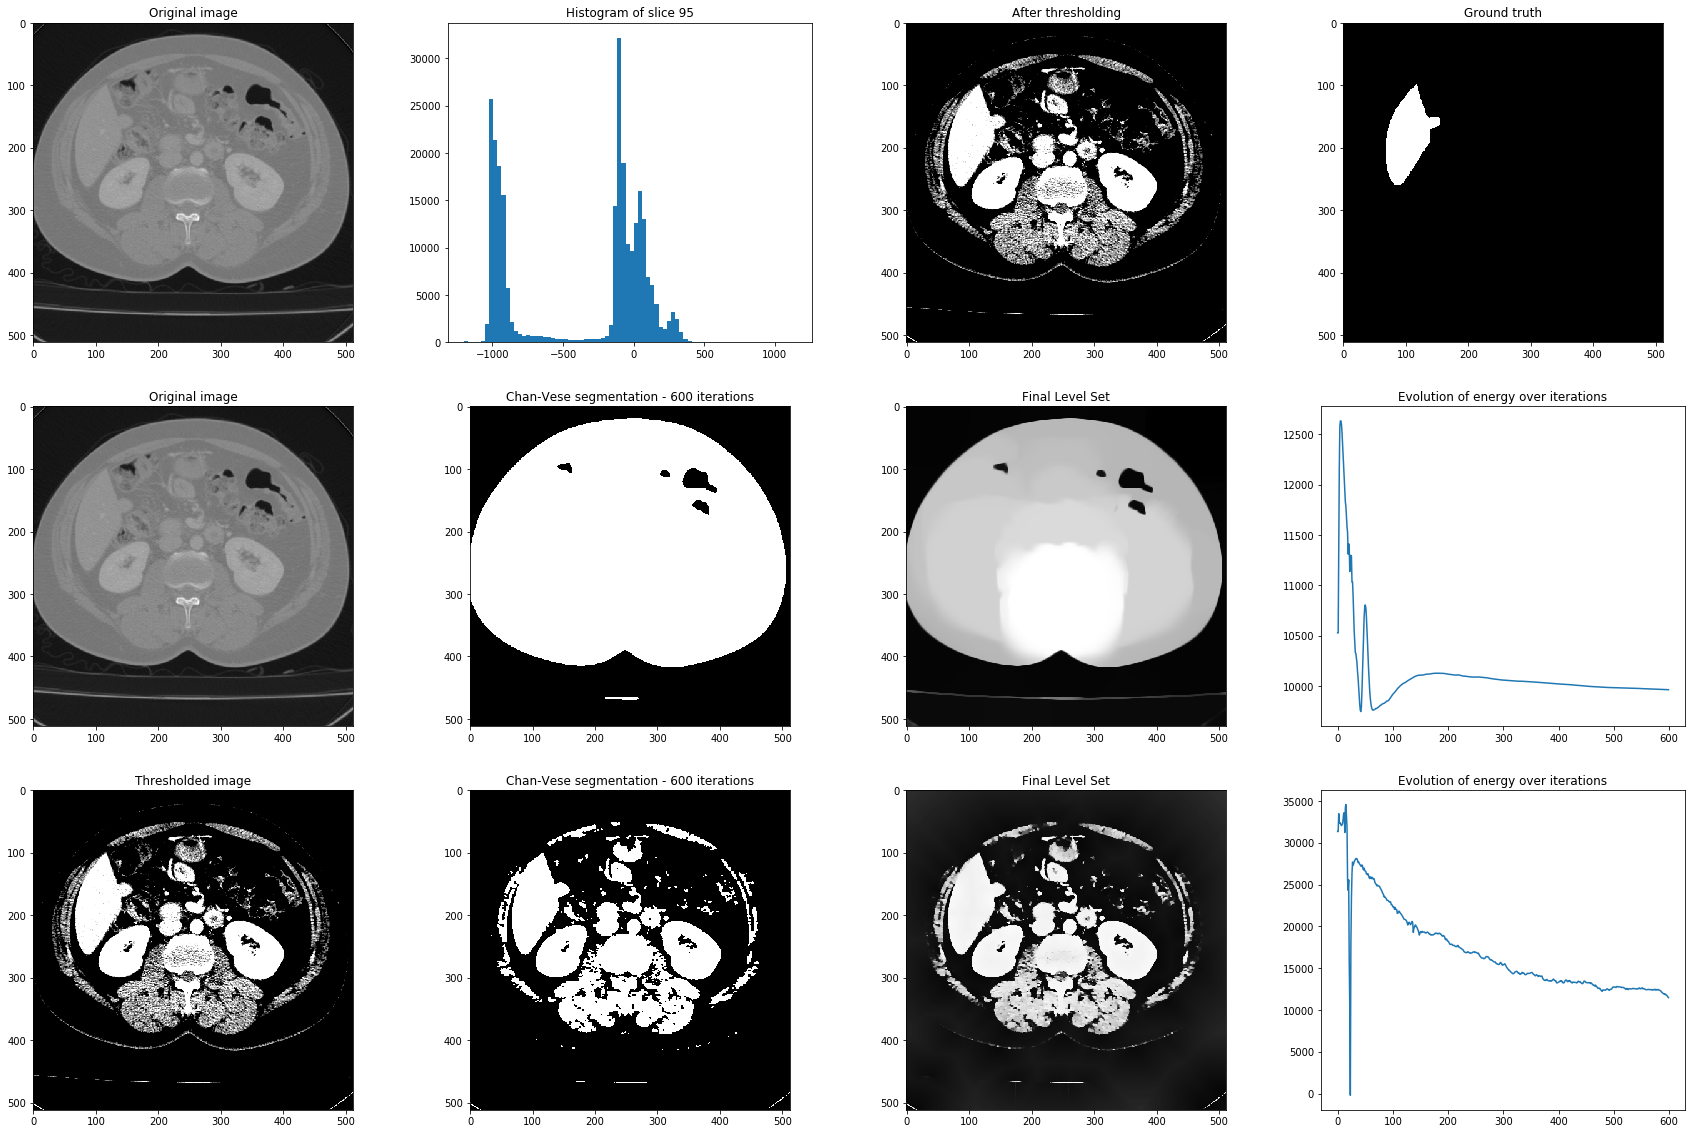

In [37]:

plt.figure(figsize=(30, 20))
plt.subplot(3, 4, 2)
plt.title("Histogram of slice {}".format(segment))
plt.hist(img.flatten(), bins=80)[2]


# plt.figure(figsize=(15, 15))
plt.subplot(3, 4, 1)
plt.title("Original image")
plt.imshow(img, cmap='gray')
plt.subplot(3, 4, 3)
plt.title("After thresholding")
plt.imshow(img_norm, cmap='gray')
plt.subplot(3, 4, 4)
plt.title("Ground truth")
plt.imshow(ground, cmap='gray')


# plt.figure(figsize=(10, 10))

plt.subplot(3, 4 ,5)
plt.title("Original image")
plt.imshow(img, cmap='gray')

plt.subplot(3, 4, 6)
plt.title("Chan-Vese segmentation - {} iterations".format(len(cv_img[2])))
plt.imshow(cv_img[0], cmap='gray')

plt.subplot(3, 4, 7)
plt.title("Final Level Set")
plt.imshow(cv_img[1], cmap='gray')

plt.subplot(3, 4, 8)
plt.title("Evolution of energy over iterations")
plt.plot(cv_img[2])


# plt.figure(figsize=(10, 10))

plt.subplot(3, 4 ,9)
plt.title("Thresholded image")
plt.imshow(img_norm, cmap='gray')

plt.subplot(3, 4, 10)
plt.title("Chan-Vese segmentation - {} iterations".format(len(cv_img[2])))
plt.imshow(cv_img_norm[0], cmap='gray')

plt.subplot(3, 4, 11)
plt.title("Final Level Set")
plt.imshow(cv_img_norm[1], cmap='gray')

plt.subplot(3, 4, 12)
plt.title("Evolution of energy over iterations")
plt.plot(cv_img_norm[2])

plt.savefig("./results/Slice {}.png".format(segment), bbox_inches='tight')




In [27]:
final = cv_img_norm[0]

In [28]:
score = dice(final, ground)
print(score)

0.24988151465132621
